<a href="https://colab.research.google.com/github/Git-Ilan/Automated-multi-choice-test-system/blob/main/Automated_multi_choice_test_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automated multi-choice test system**

In [ ]:
!pip install pillow
!pip install pdf2image
!apt-get install poppler-utils 
!pip install openpyxl
!pip install XlsxWriter

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from ipywidgets import interact_manual, interact, widgets, Layout, fixed
from IPython.display import display, Markdown, Latex
from scipy import signal
import os
import tempfile
from pdf2image import convert_from_path
from PIL import Image
from openpyxl import Workbook
import xlsxwriter
from google.colab import files
import progressbar
from time import sleep
import progressbar
from time import sleep

%matplotlib inline

  Created wheel for pdf2image: filename=pdf2image-1.12.1-cp36-none-any.whl size=9027 sha256=207e2e963e8ad8bbd05c0868ec78c4add48525a70808f7a4c9510fee3f2df63c
  Stored in directory: /root/.cache/pip/wheels/0f/80/3a/fac1dc0f7dbe12c805b9dc6497f325f0e9f9cedbec3ab0185b
Successfully built pdf2image
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 154 kB of archives.
After this operation, 613 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 poppler-utils amd64 0.62.0-2ubuntu2.10 [154 kB]
Fetched 154 kB in 1s (178 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 134448 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.62.0-2ubuntu2.10_amd64.deb ...
Unpacking poppler-utils (0.62.0-2ubuntu2.

In [ ]:
def convert_pdf_to_image(file_path):
    '''
    Create list of image from PDF file
    '''
    
    # save temp image files in temp dir, delete them after we are finished
    with tempfile.TemporaryDirectory() as temp_dir:
        # convert pdf to multiple image
        images = convert_from_path(file_path, output_folder=temp_dir,size=(1241,1754))
        # save images to temporary directory
        temp_images = []
        for i in range(len(images)):
            image_path = f'{temp_dir}/{i}.png'
            images[i].save(image_path, 'PNG')
            temp_images.append(image_path)
        # read images into pillow.Image
        imgs = list(map(Image.open, temp_images))
    return images

In [ ]:
def calc_vector(x,y, ort1, mx, my):
  '''
  Rotate a point (x,y) with a given angle and Center point of rotation (mx,my)
  '''
  
  x1 = ((x - mx) * np.cos(ort1)) - ((y - my) * np.sin(ort1)) + mx                                 
  y1 =((x - mx) * np.sin(ort1)) + ((y - my) * np.cos(ort1)) + my
  return (np.int(x1),np.int(y1))

In [ ]:
def my_hough_rectangle(edge_map, thick, width, llength,min_angle,max_angle,ddelta,needbar=False,Extream=False):
    '''
    Find whrere our rectangle locate in the image and return array with 4 values:

    1+2. The point in right & down location for best match of kernel on the image
    3.   Match percentage
    4.   Angle of the rotation

    '''

    #List of edge of rectangle with his center point
    edges_list = [(thick,thick),
                  (width+thick,thick),
                  (width+thick,llength+thick),
                  (thick,llength+thick),
                  (int(0.5*width)+thick,int(0.5*llength)+thick)]


    res_points = np.array([[0, 0, 0, 0]])
    angle = min_angle # starting angle

    ######################################################################
    # In case we don't find match, we can use "Extream" option which     #
    # takes smaller angle in each loop                                   #
    ######################################################################
    if Extream == False :
      delta_ang = (2*(2*np.pi))/(360) # Size of jumps in angle 0.01
      number_of_check = max(int(max_angle / delta_ang),2)
    else:
      delta_ang = 0.005
      number_of_check = 630

    if needbar==True:
      tt=0                               
      bar = progressbar.ProgressBar(maxval=number_of_check, \
      widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
      bar.start()
    
    # Checks all rotations with jumps of delta_ang
    while angle < max_angle: 
      edges=[]
      # Find new rotate edges point of rectangle
      for (x,y) in edges_list:
        edges.append(calc_vector(x,y, angle, edges_list[4][0], edges_list[4][0]))
      
      #############################################################
      # Some points may get negative values after rotation, hence #
      # we need to turn all these points to positve values points #
      #############################################################
      if  angle <= np.pi/2 :
        add1 = 0- edges[3][0]  # X
        add2 = 0- edges[0][1]  # Y 
        local_llength   = np.absolute (edges[0][1] - edges[2][1])
        local_width     = np.absolute (edges[1][0] - edges[3][0])
      else :
        add1 = 0 - edges[2][0]  # X
        add2 = 0 - edges[3][1]  # Y 
        local_llength   = np.absolute (edges[3][1] - edges[1][1])
        local_width     = np.absolute (edges[2][0] - edges[0][0])
      
      edges2=[]
      for (x,y) in edges:
        edges2.append((x+add1,y+add2))

      # Cerate the new Kernel of rotate rectangle 
      rectangl   = np.zeros((local_llength+thick,local_width+thick))
      cv2.line(rectangl, edges2[0], edges2[1], (255, 0, 0), thick)
      cv2.line(rectangl, edges2[1], edges2[2], (255, 0, 0), thick)
      cv2.line(rectangl, edges2[2], edges2[3], (255, 0, 0), thick)
      cv2.line(rectangl, edges2[3], edges2[0], (255, 0, 0), thick)
      rectangl= rectangl/255


      # Compute hough transform
      res  = signal.convolve(edge_map, rectangl  , mode='full')

      # Normlize the resultes with circumference of a rectangle (w,l)
      res = res / (2*width + 2*llength)

      # Save the results that have passed the threshold percentage "ddelta"
      new_res = np.array([[x, y,z,angle] for x,y,z in zip(np.where(res>ddelta)[0], np.where(res>ddelta)[1], res[np.where(res>ddelta)])])
      if len(new_res)>0:
        res_points = np.append (res_points , new_res ,axis=0  )

      # Compute next angle
      angle = angle + delta_ang

      # Update progressbar
      if needbar==True:
        bar.update(tt+1)
        tt=tt+1
    
    if needbar==True: 
      bar.finish()
      print (" ")
    return res_points[np.where(res_points == np.amax(res_points[:,2]))[0]][0]

In [ ]:
def apply_canny(img,th1,th2):
  '''
  Find edge map with Canny algorithm
  '''

  rec_canny = np.zeros_like(img)
  rec_canny = cv2.Canny(img, threshold1=th1, threshold2=th2)/255
  
  return rec_canny

In [ ]:
def rotate_img(rec_img, rec_canny_img, B_Thick,B_width,B_Length,M_Thick,M_width,M_Length,succses, scale=1.0):
  '''
  Look for the angle of deviation of the image
  '''
  
  # Find the angle and the location of the student's answers
  result_Big   = my_hough_rectangle(rec_canny,B_Thick,B_width,B_Length,0,np.pi,succses,True)

  # In case we didn't find a match, we will search with smaller checks of angles
  if result_Big[2]==0 :
    result_Big = my_hough_rectangle(rec_canny,B_Thick,B_width,B_Length,0,np.pi,succses,True,True)

  # Search the location of test number
  angle_res = result_Big[3]
  result_small = my_hough_rectangle(rec_canny,M_Thick,M_width,M_Length,angle_res,angle_res+0.0001,succses)
  
  print (result_Big)
  print (result_small)

  # Base on the location of both tables, we know how to routet the image
  angle_res = (result_Big[3]*360)/(2*np.pi)

  if   angle_res == 0 :
    angle90 = 0
  elif (result_Big[1] <= result_small[1] ) & (result_Big[0] <= result_small[0] ):
    angle90 = angle_res   + 0
  elif (result_Big[1] <= result_small[1] ) & (result_Big[0] >= result_small[0] ):
    angle90 = angle_res   + 180
  elif (result_Big[1] >= result_small[1] ) & (result_Big[0] <= result_small[0] ):
    angle90 = angle_res   + 0
  elif (result_Big[1] >= result_small[1] ) & (result_Big[0] >= result_small[0] ):
    angle90 = angle_res   + 180

  # Perform counter clockwise rotation holding at the center.
  (h, w) = rec_img.shape[:2]
  img_center = (w / 2, h / 2)
  M = cv2.getRotationMatrix2D(img_center, angle90, scale)
  rotatedd = cv2.warpAffine(rec_canny_img, M, (w, h)) 

  return rotatedd

In [ ]:
def find_cols_coordinates(img_s,Thick,Width,LLength,succses):
  '''
  return the table 
  '''

  # Find the table
  result2 = my_hough_rectangle(New_rotated_img,Thick,Width,LLength,0,0.01,succses)
  print (result2)

  # Take out the part of checkboxes from image.
  C_point = (int(result2[1]),int(result2[0]))
  D_point = (int(result2[1]),int(result2[0])-LLength)
  A_Point = (int(result2[1]-Width),int(result2[0])-LLength)
  B_point = (int(result2[1]-Width),int(result2[0]))

  img = New_rotated_img[A_Point[1]:C_point[1],A_Point[0]:C_point[0]]

  return img

In [ ]:
def draw_lines(imglines, Thick, width, LLength, n_row, n_column):
  '''
  Draw lines on the table img for show the final result later in the project
  '''
  # Convert image to [0,255] for draw lines
  imglines = imglines * 255

  # Print rows edge of the checkbox
  k= int (Thick/2)
  cv2.line(imglines, (0,Thick) , (width,Thick) , (255,0,0), Thick)
  while k <=  LLength +Thick:
    cv2.line(imglines, (0,k) , (width,k) , (255,0,0), Thick)
    k = k + n_row

  # Print columns edge of the checkbox
  k= -Thick
  cv2.line(imglines, (Thick,0) , (Thick,LLength) , (255,0,0), Thick)
  while k <=  width +Thick:
    cv2.line(imglines, (k,0) , (k,LLength) , (255,0,0), Thick)
    k = k + n_column

  return imglines

In [ ]:
def create_x_kernel(n_row, n_column, Thick,multi=1):
  '''
  Create a X kernel with negative values for the rest of the background
  '''

  X_Krenel = np.zeros((n_row,n_column))
  cv2.line(X_Krenel, (Thick,Thick)           , (n_column-Thick,n_row-Thick) , (255,0,0), multi*Thick)
  cv2.line(X_Krenel, (Thick,n_row-Thick)     , (n_column-Thick,Thick)       , (255,0,0), multi*Thick)
  X_Krenel = X_Krenel/255

  X_Krenel[np.where(X_Krenel==0)]=-1

  return X_Krenel

In [ ]:
def divide_img_to_boxes(Thick, s_row, LLength, s_column, img, X_Krenel,width):
  '''
  Take apart the image into list of boxes and calculates the match to X 
  for each box.
  '''
  
  Check_list = []
  Conv_res = []
  i=int (Thick/2)+2*s_row
  while i <=  LLength +Thick:
    j= -Thick+2*s_column
    le_img = img[i-s_row:i,Thick:s_column-Thick]
    Conv_res.append(np.amax(signal.convolve(X_Krenel, le_img  , mode='same')))
    Check_list.append(le_img)
    while j <=  width +Thick-s_column:
      le_img = img[i-s_row:i,j-s_column:j]
      Conv_res.append(np.amax(signal.convolve(X_Krenel, le_img  , mode='same')))
      Check_list.append(le_img)
      j = j + s_column
    i = i + s_row

  return(Conv_res)

In [ ]:
def find_xs_in_img(Conv_r,r_size, c_size, Thick,multi):
  '''
  Return the positon of X marks in the tables
  '''

  Real_kernel = create_x_kernel(r_size, c_size, Thick, multi)
  Min_kernel  = create_x_kernel(r_size, c_size, 1, 1)

  # Max value of the result (that need to be match to X)
  maxi=np.amax(Conv_r)

  # In case we will not find any match to X, we will have min value for the result need to have
  mini=np.amax(signal.convolve(Real_kernel, Min_kernel  , mode='full'))

  resultt = np.where((Conv_r>(maxi/1.3)) &  (Conv_r>=(mini)))

  The_result = resultt[0] + 1 
  print (The_result)
  return The_result

In [ ]:
def show_results(check_res, Thick, p_row, LLength, p_column, X_Krenel, Conv_rx, Width):
  '''
  Show the final result and marks the box it found in the table
  '''

  img = check_res
  i=int (Thick/2)+2*p_row
  z=1
  while i <=  LLength +Thick:
    j= -Thick+2*p_column


    if (z in Conv_rx):

      ttt = img[i-int(p_row):i,0:int(p_column)]
      (h1, w1)= X_Krenel.shape[:2]
      (h2, w2)= ttt.shape[:2]

      h3 = min(h1,h2)
      w3 = min(w1,w2)

      img[i-int(p_row):(i-int(p_row)+h3),0:w3] = X_Krenel[0:h3,0:w3]*255

    z=z+1
    while j <=  Width +Thick-p_column:
      if (z in Conv_rx):

        ttt = img[i-int(p_row):i,j-int(p_column):j]
        (h1, w1)= X_Krenel.shape[:2]
        (h2, w2)= ttt.shape[:2]

        h3 = min(h1,h2)
        w3 = min(w1,w2)

        img[i-int(p_row):(i-int(p_row)+h3),j-int(p_column):(j-int(p_column)+w3)] = X_Krenel[0:h3,0:w3]*255
        
      j = j + p_column
      z=z+1
    i = i + p_row

  return img

In [ ]:
def find_student_answers(Rows, Result,the_number):
  '''
  Takes all the marks we found and convert them to array 
  '''
  Anwsers = np.array([])
  Anwsers=np.append(Anwsers,the_number) 

  i = 0
  for i in range (Rows-1): # Number of a,b,c,d
    ccheck = Result[np.where((Result>(Sections-1)*i) &  (Result<=(Sections-1)*(i+1)))]
    if  len(ccheck)>1 :
      Anwsers=np.append(Anwsers,'Eror: Multi chose')
    elif  len(ccheck)==0 :
      Anwsers=np.append(Anwsers,'Eror: didnt chose answer')
    elif  ccheck[0]%((Sections-1))==0 :
      Anwsers=np.append(Anwsers,'A')      
    elif  ccheck[0]%((Sections-1))==3 :
      Anwsers=np.append(Anwsers,'B')      
    elif  ccheck[0]%((Sections-1))==2 :
      Anwsers=np.append(Anwsers,'C')     
    elif  ccheck[0]%((Sections-1))==1 :
      Anwsers=np.append(Anwsers,'D')      

  return Anwsers

In [ ]:
def find_student_number(testnumber):
  '''
  Takes all the marks we found and convert them to array number of test
  '''

  if  len(testnumber)>3 :
    return 'Error : Too mach marks in the test number table'
  elif  len(testnumber)<3 :
    return 'Error : Not enough marks in the test number table'

  no1= True
  no2= True
  no3= True
  
  number = 0
  for i in range (3):
    if   (testnumber[i]%3==0) & no1 :
      number = number +(testnumber[i]/3) * 100
      no1= False
    elif ((testnumber[i])%3==1) & no2 :
      number = number +((testnumber[i]-1)/3) * 10
      no2= False
    elif ((testnumber[i])%3==2) & no3 :
      number = number +((testnumber[i]-2)/3) * 1
      no3= False
    else :
      return 'Error : The student do not know how to read the Instructions'
   
  return str(int(number))

In [ ]:
def shows_levels(img_list):
    '''
    Prints all the steps in the program
    '''
    
    name_list = ["Original","Canny","Routeded","checkbox","Student answers","Test number"]
    fig=plt.figure(figsize=(10, 10))
    columns = 3
    rows = 2
    for img,i,namee in zip(img_list,range(1, columns*rows +1),name_list):
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, cmap='gray')
        plt.title(namee)
    plt.show()

In [ ]:
def sort_Grades(arr_gra,ziun):
  if   ziun < 55 :
    arr_gra [0] = arr_gra [0] + 1
  elif ziun < 60 :
    arr_gra [1] = arr_gra [1] + 1
  elif ziun < 70 :
    arr_gra [2] = arr_gra [2] + 1
  elif ziun < 80 :
    arr_gra [3] = arr_gra [3] + 1
  elif ziun < 90 :
    arr_gra [4] = arr_gra [4] + 1
  else :
    arr_gra [5] = arr_gra [5] + 1
    
  return arr_gra

--2020-03-10 10:14:43--  https://5be61856-6b67-4e10-8241-69bbd7518830.usrfiles.com/ugd/5be618_b7bcdf31f2cb40288b9c88971fc48944.pdf
Resolving 5be61856-6b67-4e10-8241-69bbd7518830.usrfiles.com (5be61856-6b67-4e10-8241-69bbd7518830.usrfiles.com)... 34.102.176.152
Connecting to 5be61856-6b67-4e10-8241-69bbd7518830.usrfiles.com (5be61856-6b67-4e10-8241-69bbd7518830.usrfiles.com)|34.102.176.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3647092 (3.5M) [application/pdf]
Saving to: ‘pp.pdf’

pp.pdf              100%[===================>]   3.48M  13.8MB/s    in 0.3s    

2020-03-10 10:14:43 (13.8 MB/s) - ‘pp.pdf’ saved [3647092/3647092]



[========================================================================] 100%


 
[1.65400000e+03 5.23000000e+02 9.67279412e-01 0.00000000e+00]
[1.64800000e+03 9.83000000e+02 9.87149533e-01 0.00000000e+00]
[1.65400000e+03 5.23000000e+02 9.67279412e-01 0.00000000e+00]
[ 3  6 12 20 22 27 32 34 39]
[1.64800000e+03 9.83000000e+02 9.87149533e-01 0.00000000e+00]
[ 8 13 21]


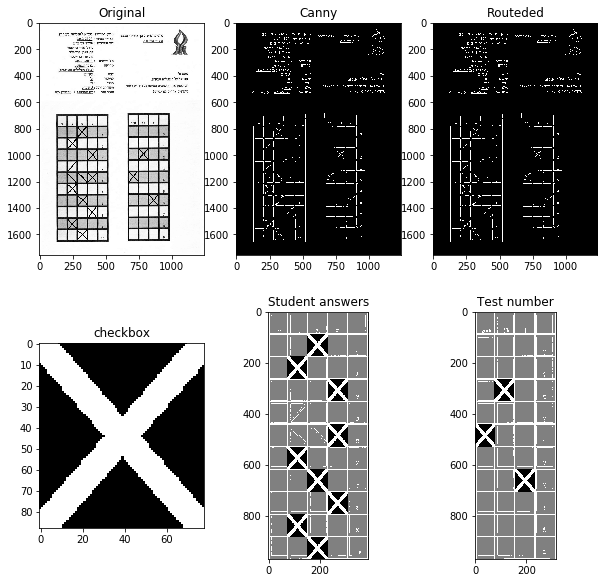

[========================================================================] 100%


 
[1.77500000e+03 7.93000000e+02 9.23529412e-01 2.79252680e+00]
[1.58500000e+03 1.22400000e+03 9.59501558e-01 2.79252680e+00]
[1.6540000e+03 5.2300000e+02 8.7340806e-01 0.0000000e+00]
[ 2  7 14 22 28 31 34]
[1.64800000e+03 9.83000000e+02 9.27476164e-01 0.00000000e+00]
[12 14 19]


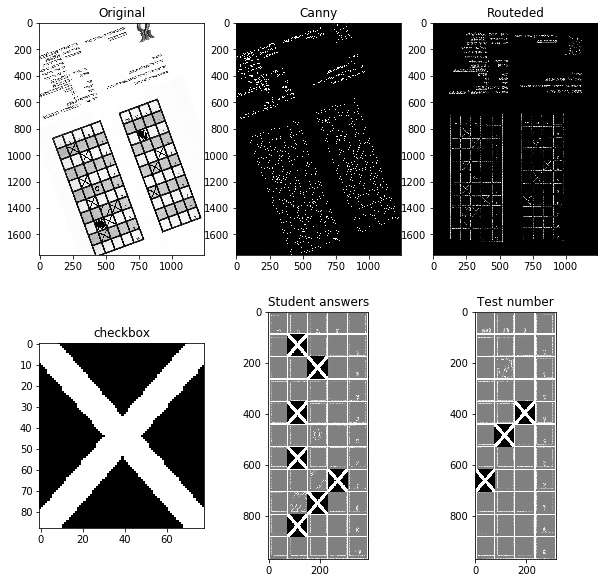

[========================================================================] 100%


 
[1.79300000e+03 8.98000000e+02 1.25698529e+00 2.65290046e+00]
[1.75700000e+03 8.97000000e+02 1.25973520e+00 2.65290046e+00]
[1.65400000e+03 5.23000000e+02 1.19487269e+00 0.00000000e+00]
[ 5 10 15]
[1.64800000e+03 9.83000000e+02 1.19630694e+00 0.00000000e+00]
[28 29 30]


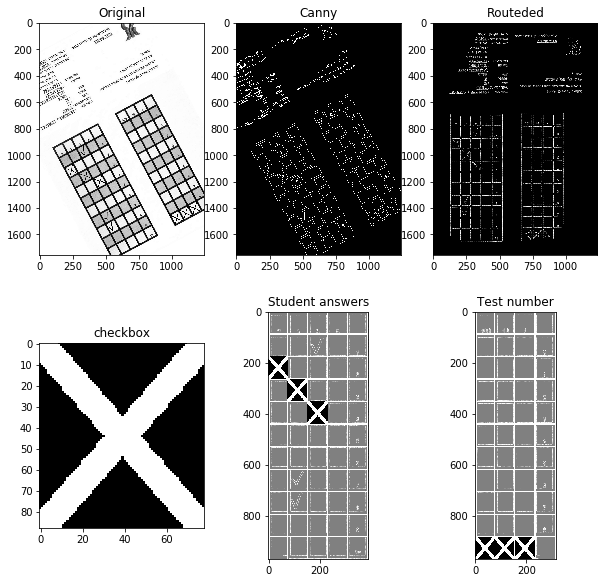

[========================================================================] 100%


 
[1.63900000e+03 7.03000000e+02 9.61029412e-01 1.04719755e-01]
[1.68100000e+03 1.16200000e+03 9.82476636e-01 1.04719755e-01]
[1.63800000e+03 6.84000000e+02 9.20032456e-01 0.00000000e+00]
[]
[1.63100000e+03 1.14400000e+03 9.40674208e-01 0.00000000e+00]
[1 5 9]


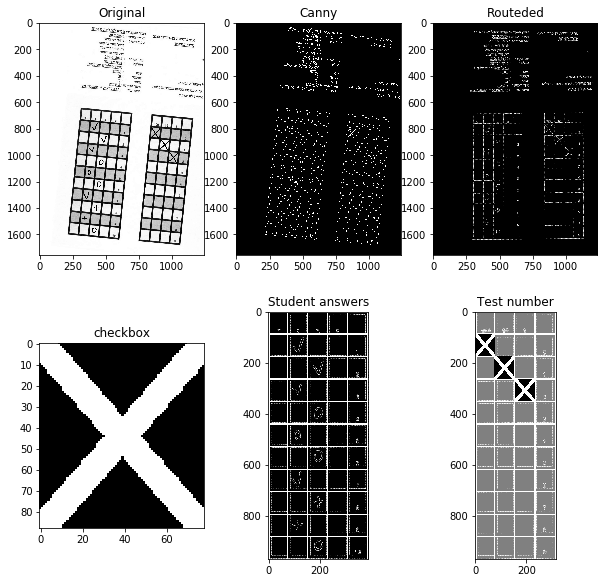

[========================================================================] 100%


 
[1.02300000e+03 1.20100000e+03 8.93382353e-01 2.79252680e+00]
[1.18600000e+03 7.00000000e+02 9.53660436e-01 2.79252680e+00]
[1.63500000e+03 4.71000000e+02 8.08681353e-01 0.00000000e+00]
[ 2  7 12 15 20 23 28 31 36 40]
[1.62800000e+03 9.31000000e+02 8.87433679e-01 0.00000000e+00]
[12 14 16]


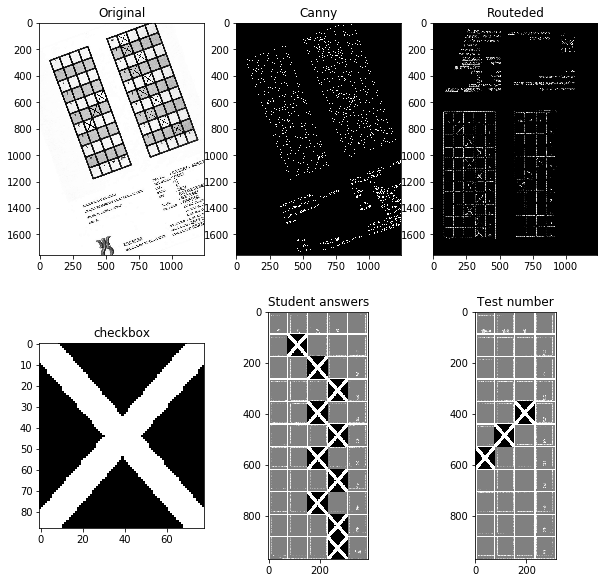

In [ ]:
if __name__ == "__main__":
  Big_width  = 392
  Big_Length = 968
  Mid_width  = 316
  Mid_Length = 968
  Big_Thick  = 3
  Mid_Thick  = 3
  Sections   = 5
  Rows       = 11
  n_column   = int (Big_width  / (Sections))
  n_row      = int (Big_Length / (Rows))
  m_n_column = int (Mid_width  / (4))
  m_n_row    = int (Mid_Length / (11))
  x_kernel   = create_x_kernel(n_row, n_column, Mid_Thick,4)
  right_answers = [['B',10],['A', 10], ['B', 10],['C', 10],['B',10],['A',10],['B',10],['C',10],['B',10],['A',10]]
  histogram = np.array([0,0,0,0,0,0]) 
  vvv = ["0-55","56-59","60-69","70-79","80-89","90-100"]

  !wget https://5be61856-6b67-4e10-8241-69bbd7518830.usrfiles.com/ugd/5be618_b7bcdf31f2cb40288b9c88971fc48944.pdf  -O pp.pdf
  List_of_exams = convert_pdf_to_image('pp.pdf')
  students = len(List_of_exams) #1

  workbook = xlsxwriter.Workbook('arrays.xlsx')
  worksheet = workbook.add_worksheet()
  worksheet.add_table(0, 0, students, Rows,{'columns': [{'header': 'ID'},
                                          {'header': 'Q_01'},
                                          {'header': 'Q_02'},
                                          {'header': 'Q_03'},
                                          {'header': 'Q_04'},
                                          {'header': 'Q_05'},
                                          {'header': 'Q_06'},
                                          {'header': 'Q_07'},
                                          {'header': 'Q_08'},
                                          {'header': 'Q_09'},
                                          {'header': 'Q_10'},
                                          {'header': 'Grade'}
                                          ]})
  chart = workbook.add_chart({'type': 'bar'})

  for student in range(students):
    ######################################
    # Part I - corect angle of the image #
    ######################################
    rec_img = np.asarray(List_of_exams[student]) 
    rec_canny = apply_canny(rec_img,200,400) #2
    New_rotated_img = rotate_img(rec_img, rec_canny, Big_Thick,Big_width,Big_Length,Mid_Thick,Mid_width,Mid_Length,0.8) #3

    ########################################
    # Part II - find students answer table #
    ########################################
    newimg = find_cols_coordinates(New_rotated_img,Big_Thick,Big_width,Big_Length,0.8) #4
    nnewimg = newimg
    img_lines = draw_lines(newimg, Mid_Thick, Big_width, Big_Length, n_row, n_column) #5
    Conv_res = divide_img_to_boxes(Mid_Thick, n_row, Big_Length, n_column, newimg, x_kernel,Big_width)
    The_result = find_xs_in_img(Conv_res,n_column, Mid_Thick,4,4)#6
    img_res1 = show_results(img_lines, Mid_Thick, n_row, Big_Length, n_column, x_kernel, The_result, Big_width)#7

    ##################################
    # Part III - find student number #
    ##################################
    newimg2 = find_cols_coordinates(newimg,Mid_Thick,Mid_width,Mid_Length,0.8) #4
    nnewimg2 = newimg2
    img_lines2 = draw_lines(newimg2, Mid_Thick, Mid_width, Mid_Length, m_n_row, m_n_column) #5
    Conv_res2 = divide_img_to_boxes(Mid_Thick, m_n_row, Mid_Length, m_n_column, newimg2, x_kernel,Mid_width)
    test_number = find_xs_in_img(Conv_res2,n_column, Mid_Thick,4,4)#6
    img_res2 = show_results(img_lines2, Mid_Thick, m_n_row, Mid_Length, m_n_column, x_kernel, test_number, Mid_width)#7

    #####################################
    # Part IV - add the result to excel #
    #####################################
    stusent_number = find_student_number(test_number-1)
    student_answers = find_student_answers(Rows, The_result,stusent_number)#8
    grade = 0
    for i in range(len(student_answers)-1):
      if right_answers[i][0] == student_answers[i+1]:
        grade = grade + right_answers[i][1]
    student_answers = np.append(student_answers,[str(grade)])
    histogram = sort_Grades (histogram,grade)
    worksheet.write_row(student+1,0, student_answers)#9
    shows_levels([rec_img,rec_canny,New_rotated_img,x_kernel,img_res1,img_res2])#10

  worksheet.write_column('AU1', histogram)
  worksheet.write_column('AV1', vvv)
  chart.add_series({'categories': '=Sheet1!$AV$1:$AV$6','values': '=Sheet1!$AU$1:$AU$6'})
  chart.set_legend({'delete_series': [0]})
  worksheet.insert_chart(student+3,0, chart)
  workbook.close()

In [ ]:
#Run this part again for download
files.download("arrays.xlsx")

# Final result
![alt text](https://static.wixstatic.com/media/5be618_d57836d78d224e4480cbbb0845921964~mv2.jpg)